In [1]:
import networkx as nx
from ete3 import PhyloTree
import networkx as nx
import torch
# from torch_geometric.data import Data
import numpy as np

def remove_single_child_nodes(tree):
    """
    Remove single child nodes from an ete3 PhyloTree while preserving the distances.
    """
    # Recursive function to perform post-order traversal
    def traverse(node):
        if not node.is_leaf():
            children = node.get_children()
            # If this node has a single child
            if len(children) == 1:
                child = children[0]
                # Add the distance of the current node to the child
                child.dist += node.dist
                # Re-parent the child to the current node's parent
                parent = node.up
                node.detach()
                if parent is None:  # This means the node was the root
                    child.up = None
                    tree.set_outgroup(child)
                else:
                    parent.add_child(child)
                traverse(child)
            else:
                # Continue traversal for all children
                for child in children:
                    traverse(child)
    traverse(tree)
    return tree

def ete3_to_networkx(tree):
    """
    Convert an ete3 PhyloTree to a weighted networkx graph.
    """
    graph = nx.Graph()
    # Recursive function to traverse the tree and add nodes/edges to the graph.
    def traverse(node):
        graph.add_node(node.name)
        for child in node.children:
            graph.add_edge(node.name, child.name, weight=child.dist)
            traverse(child)
    traverse(tree)
    return graph

def rename_tree(tree):
    # Perform a DFS traversal and rename nodes incrementally
    name_counter = 0  # Initialize the name counter
    dict_ = {}
    def rename_nodes_dfs(node, counter):
        dict_[node.name] = counter
        node.name = counter  # Assign the new name
        counter += 1  # Increment the name counter
        for child in node.children:
            counter = rename_nodes_dfs(child, counter)  # Recursively process children
        return counter
    # Start the DFS traversal from the root
    name_counter = rename_nodes_dfs(tree, name_counter)
    return tree, dict_

from collections import deque

def rename_tree_bfs(tree):
    # Perform a BFS traversal and rename nodes incrementally starting from 1
    name_counter = 1  # Initialize the name counter to 1
    dict_ = {}
    queue = deque([tree])  # Initialize the queue with the root node
    while queue:
        node = queue.popleft()  # Dequeue the node
        # dict_[node.name] = name_counter
        dict_[name_counter] = node.name
        node.name = name_counter  # Assign the new name
        name_counter += 1  # Increment the name counter
        for child in node.children:
            queue.append(child)  # Enqueue the children for processing
    return tree, dict_

/home/mridul/anaconda3/envs/n2v/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# path = '/raid/mridul/fish/cleaned_metadata.tre'
# tree = PhyloTree(path, format=1)
# tree_org = PhyloTree(path, format=1)

# tree = remove_single_child_nodes(tree)
# tree, mapping = rename_tree_bfs(tree)
# graph = ete3_to_networkx(tree)

In [3]:
path = '/raid/mridul/CUB_190_split/official/1_tree-consensus-Hacket-AllSpecies-cub-names.phy'
cub_tree = PhyloTree(path, format=1)
cub_tree = remove_single_child_nodes(cub_tree)
cub_tree, cub_mapping = rename_tree_bfs(cub_tree)
cub_graph = ete3_to_networkx(cub_tree)

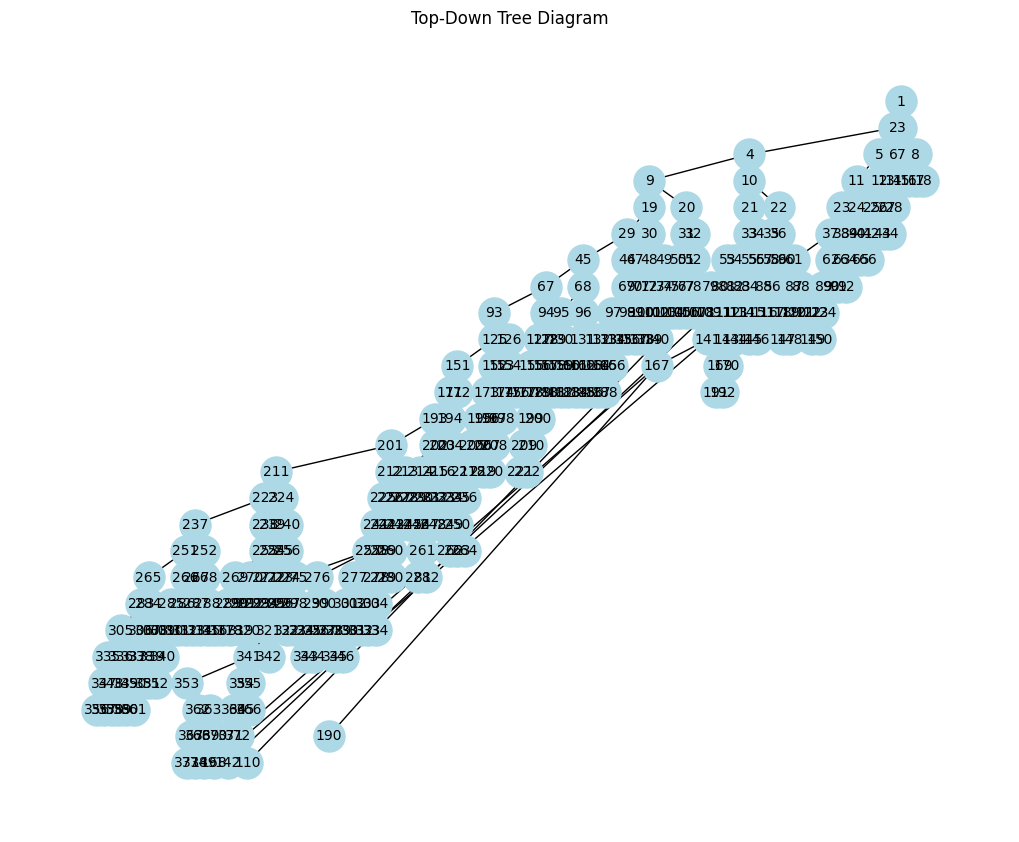

In [4]:
# Define the layout for the tree (top-down)
layout = nx.nx_agraph.graphviz_layout(cub_graph, prog="dot")
import matplotlib.pyplot as plt

# Draw the tree
plt.figure(figsize=(10, 8))
nx.draw(cub_graph, pos=layout, with_labels=True, node_size=500, node_color="lightblue", font_size=10, font_color="black")
plt.title("Top-Down Tree Diagram")
plt.show()

In [5]:
graph = cub_graph

In [6]:
# nx.shortest_path(graph, source=1, target=44, weight='weight')

In [7]:
# graph.get_edge_data(11, 15)['weight']

In [8]:
def get_weight_info(traversal,  G):
    i=0
    final_traversal = []
    for j in range(1, len(traversal)):
        source = traversal[i]
        target = traversal[j]
        edge_weight = G.get_edge_data(source, target)['weight']
        final_traversal.append('<N>')
        final_traversal.append(source)
        final_traversal.append('<E>')
        final_traversal.append(round(edge_weight, 2))
        i += 1
    final_traversal.append('<N>')
    final_traversal.append(target)
    return final_traversal

In [9]:
leaf_nodes = [node for node in cub_graph.nodes() if cub_graph.degree(node) == 1]
filtered_mapping = {key: value for key, value in cub_mapping.items() if key in leaf_nodes}

In [10]:
len(leaf_nodes)

190

In [11]:
import pickle
name_conversion_file = "/home/mridul/data/cub_phylogeny/cub_name_conversion.pkl"

# ott_ids = set()
# ott_id_dict={}

# with open(name_conversion_file, 'rb') as f:
#     ott_ids, ott_id_dict = pickle.load(f)

# modified_dict = {'ott' + str(value): key for key, value in ott_id_dict.items()}

In [12]:
# node_num_to_name = {leaf: modified_dict[filtered_mapping[leaf]] for leaf in leaf_nodes}
# name_to_node_number = {value: key for key, value in node_num_to_name.items()}

In [13]:
import pdb
name_traversal = {}
max_length = 0
for leaf in leaf_nodes:
    # pdb.set_trace()
    shortest_path = nx.shortest_path(cub_graph, source=1, target=leaf)
    shortest_path = get_weight_info(shortest_path, cub_graph)
    str_shortest_path = ' '.join(map(str, shortest_path))
    # name_traversal[modified_dict[filtered_mapping[leaf]]] = str_shortest_path
    name_traversal[cub_mapping[leaf]] = str_shortest_path
    if len(str_shortest_path) > max_length:
        max_length=len(str_shortest_path)
    # pdb.set_trace()
name_traversal
max_length

422

In [16]:
len(name_traversal.keys())

190

In [21]:
max_key, max_value = max(name_traversal.items(), key=lambda kv: len(kv[1]))
max_key, max_value

('174.Palm_Warbler',
 '<N> 1 <E> 16.94 <N> 2 <E> 0.44 <N> 4 <E> 1.77 <N> 9 <E> 13.72 <N> 19 <E> 9.21 <N> 29 <E> 6.78 <N> 45 <E> 5.77 <N> 67 <E> 0.95 <N> 93 <E> 11.43 <N> 125 <E> 1.38 <N> 151 <E> 3.12 <N> 171 <E> 5.66 <N> 193 <E> 2.75 <N> 201 <E> 1.43 <N> 212 <E> 5.76 <N> 225 <E> 1.01 <N> 241 <E> 0.82 <N> 257 <E> 0.43 <N> 275 <E> 2.78 <N> 297 <E> 0.25 <N> 321 <E> 0.21 <N> 341 <E> 0.14 <N> 353 <E> 0.15 <N> 362 <E> 0.27 <N> 367 <E> 4.04 <N> 374')

In [14]:
with open('/home/mridul/data/cub_phylogeny/cub_name_to_node_bfs_weighted.pkl', 'wb') as pickle_file:
    pickle.dump(name_traversal, pickle_file)

In [ ]:
with open('/raid/mridul/fish/name_to_node_bfs_weighted.pkl', 'wb') as pickle_file:
    pickle.dump(name_traversal, pickle_file)

In [ ]:
name_traversal['Lepisosteus osseus']

In [ ]:
with open('/raid/mridul/fish/name_to_node_bfs_weighted.pkl', 'rb') as pickle_file:
    loaded_data = pickle.load(pickle_file)

print(loaded_data)

In [ ]:
import pickle
with open('/raid/mridul/fish/name_to_node_bfs.pkl', 'rb') as pickle_file:
    loaded_data = pickle.load(pickle_file)

for i in loaded_data.items():
    print(i)
# print(loaded_data)

In [ ]:
from transformers import AutoTokenizer

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

In [ ]:
tokenizer(name_traversal['Lepisosteus osseus'], padding='max_length', max_length=77, 
                     truncation=True, return_tensors="pt", add_special_tokens=True)

In [ ]:
review = ['1', '2', '4', '8', '12', '16', '27']

In [ ]:
', '.join(map(str, [1, 2, 4, 8, 13, 19]))

In [ ]:
review_str = "1, 2, 4, 8, 12, 16, 27"

In [ ]:
tokenizer(review_str, padding='max_length', max_length=77, 
                     truncation=True, return_tensors="pt", add_special_tokens=True)['input_ids']

In [ ]:
review_str2= "1, 2, 4, 8, 12, 16, 28"
tokenizer(review_str2, padding='max_length', max_length=77, 
                     truncation=True, return_tensors="pt", add_special_tokens=True)['input_ids']

In [ ]:
review_str3= "1, 2, 4, 8, 12, 15, 28"
tokenizer(review_str3, padding='max_length', max_length=77, 
                     truncation=True, return_tensors="pt", add_special_tokens=True)['input_ids']

In [ ]:
review_str4= "1, 2, 4, 8, 12, 28, 15"
tokenizer(review_str4, padding='max_length', max_length=77, 
                     truncation=True, return_tensors="pt", add_special_tokens=True)['input_ids']